In [5]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Build Model


In [6]:
np.random.seed(42)
class DQN:
    def __init__(self,
                 InputShape = 3,
                 NActions = 40,
                 Gamma = 0.97,
                 MemorySize = 10000,
                 MinMemory = 1000,
                 UpdateTargetEveryThisEpisodes = 2,
                 Dense_no = 64,
                 BatchSize = 32,
                 Epsilon = 0.1,
                 Epsilon_Decay = 0.95,
                 learning_rate = 0.001,
                 load_weights = False,
                 high_penalty = 0.95,
                 low_penalty = 1.25
                 ):
        
        # Preset. #
        self.InputShape = InputShape

        # Hyperparameters. # (Tuneable)
        self.NActions = NActions # Number of Discretized Actions.
        self.Gamma = Gamma # Discount Factor
        self.MemorySize = MemorySize # Max Memory Size
        self.MinMemory = MinMemory # Min Memory Size before Training.
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes # Frequency of Target Update.
        self.Dense_no = Dense_no # Dense Layers
        self.BatchSize = BatchSize # Batch Size for Training.
        self.learning_rate = learning_rate
        self.high_learning_rate_penalty = high_penalty
        self.low_learning_rate_penalty = low_penalty

        # Optimiser. #
        if learning_rate == None:
            self.Optimiser = Adam()
        else: 
            self.Optimiser = Adam(learning_rate=learning_rate) # Optimiser for Training.

        self.Epsilon = Epsilon # Exploration Rate.
        self.Epsilon_Decay = Epsilon_Decay # Exploration Decay Rate.

        print(f""" 
List of Parameters:
Number of Actions: {self.NActions},
Gamma: {self.Gamma},
Learning Rate: {self.learning_rate},
Memory Size: {self.MemorySize},
Min Memory: {self.MinMemory},
Update Target Every This Episodes: {self.UpdateTargetEveryThisEpisodes},
Dense Layers: {self.Dense_no},
Batch Size: {self.BatchSize},
Epsilon: {self.Epsilon},
Epsilon Decay: {self.Epsilon_Decay},
Optimiser: {self.Optimiser.learning_rate.numpy()},
High Penalty: {self.high_learning_rate_penalty},
Low Penalty: {self.low_learning_rate_penalty}
""")
        

        # Main Model. #
        self.Main = self.Model('Main')
        if load_weights != False:
            self.Main.load_weights(load_weights)
        # Target Model. #
        self.T = self.Model('Target')
        self.update_t_weights()
        self.Memory = deque(maxlen = MemorySize)
        self.TargetUpdateCounter = 0
    
    # Create Model. #
    def Model(self, Type):

        inputs = Input(shape = (self.InputShape), name = 'Input')
        x = Dense(self.Dense_no, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.Dense_no, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateMemory(self, Information): # Update Memory.
        self.Memory.append(Information)

    def update_t_weights(self): # Update Target Model.
        self.T.set_weights(self.Main.get_weights())

    def PendulumActionConverter(self, A): # Discritize Action.
        ActualTorque = (A / self.NActions - 0.5) * 4 # Normalise to [-2, 2] 
        return ActualTorque

    def PendulumInverseActionConverter(self, A): # Undiscritize Action.
        ActualA = round((A + 2) * (self.NActions - 1) / 4)
        return(ActualA)
    
    def adjust_learning_rate_and_epsilon(self, score):
        # Define thresholds for score
        high_score_threshold = -300
        low_score_threshold = -800

        # Define learning rate and epsilon adjustment factors
        high_score_learning_rate_factor = 0.95
        low_score_learning_rate_factor = self.low_learning_rate_penalty

        mid_score_learning_rate_factor = 0.99
        mid_score_epsilon_decay = 0.99
        
        high_score_epsilon_decay = self.Epsilon_Decay
        low_score_epsilon_increase = 0.01

        # Adjust learning rate and epsilon based on score
        if score >= high_score_threshold:
            # If score is high, decrease learning rate and epsilon
            self.learning_rate *= high_score_learning_rate_factor
            self.Epsilon *= high_score_epsilon_decay
        
        if low_score_threshold < score < high_score_threshold:
            # If score is in between, decrease learning rate and epsilon
            self.learning_rate *= mid_score_learning_rate_factor
            self.Epsilon *=  mid_score_epsilon_decay

        elif score < low_score_threshold:
            # If score is low, increase learning rate and epsilon
            self.learning_rate *= low_score_learning_rate_factor
            self.Epsilon += low_score_epsilon_increase
            if self.Epsilon == 0.5:
                self.Epsilon = 0.1

        # Ensure learning rate and epsilon are within reasonable bounds
        self.learning_rate = min(max(self.learning_rate, 0.0001), 0.4)
        self.Epsilon = min(max(self.Epsilon, 0.001), 0.4)

        # Update optimizer with new learning rate
        self.Optimiser = Adam(learning_rate=self.learning_rate)

        
    def GetAction(self, env, Q): # Getting Action from Q Values.
        if np.random.rand() <= self.Epsilon:
            AStep = env.action_space.sample()
            A = self.PendulumInverseActionConverter(AStep[0])
        else:
            A = np.argmax(Q)
            A = self.PendulumActionConverter(A)
            AStep = np.array([A])
            A = self.PendulumInverseActionConverter(A)
        return A, AStep
    
    def save_weights(self, path):
        if path == None:
            return
        self.Main.save_weights('DQN_Weights/'+'Main'+path)
        self.T.save_weights('DQN_Weights/' + 'Target'+path)

    def Train(self, EndOfEpisode, Normalization = False): # Training.
        if len(self.Memory) < self.MinMemory:
            return

        TrainingData = random.sample(self.Memory, self.BatchSize)
        
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS)) # Q Values for Current State

        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.T(ListOfSNext) # Q Values for Next State.
        

        X = []
        Y = []
        for index, (S, A, R, SNext, Done) in enumerate(TrainingData): 
            if not Done:

                MaxQNext = np.max(ListOfQNext[index]) # Target Q Value for Next State.
                QNext = R + self.Gamma * MaxQNext # Sum of the reward and the discounted maximum Q-value

            else:
                QNext = R # If the episode is done, the Q-value is just the reward.

            Q = ListOfQ[index] 
            Q[A] = QNext  # Q-value for the chosen action (A) in the current state is updated to the target 

            X.append(S) # States
            Y.append(Q) # Q Values
        self.GTfit(X, Y)
                
        if EndOfEpisode:
            self.TargetUpdateCounter += 1

        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.update_t_weights()
            self.TargetUpdateCounter = 0
        
    @tf.function
    def GTfit(self, X, Y): # Gradient Tape Fit.
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))



In [7]:
def OneEpisode(dqn, _, Normalization = False):
    env = gym.make('Pendulum-v0')
    env.seed(43)
    S = env.reset()
    score = 0
    Done = False
    while not Done:
        Q = dqn.Main(S.reshape(-1, S.shape[0]))
        A, AStep = dqn.GetAction(env, Q)
        if not _ % 10 and len(dqn.Memory) >= dqn.MinMemory:
            env.render()
        SNext, R, Done, Info = env.step(AStep)
        dqn.UpdateMemory((S, A, R, SNext, Done))
        dqn.Train(Done, Normalization)
        score += R
        if Done:
            dqn.adjust_learning_rate_and_epsilon(score)
            env.close()
            return score
        S = SNext

def RunEpisodes(dqn, episodes, Normalize = False, save_weights = 'BaseWeights.h5', load_weights = False):
    import time
    STARTTIME = time.time()
    score = []
    ma = []
    for _ in range(episodes):
        s = OneEpisode(dqn, _, Normalize)
        score.append(s)
        moving_average = np.mean(score[-100:])
        ma.append(moving_average)
        if load_weights == False:
            if s == max(score):
                dqn.save_weights(f'Pendulum_{save_weights}')
        print(f'Episode {_}, Score : {s}, Moving Average : {moving_average}, Epsilon : {dqn.Epsilon}, learning rate : {dqn.learning_rate}')
        
    print(f'Total time taken: {time.time() - STARTTIME} seconds ...')
    return score, ma

## Base Model

In [8]:
EPISODES = 300
episode_number = np.arange(EPISODES)

In [21]:
dqn = DQN(InputShape = 3, Epsilon_Decay=0.99)
base_scores, base_average = RunEpisodes(dqn, EPISODES)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.97,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.99,
Optimiser: 0.0010000000474974513,

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 

Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 0, Score : -1061.3578461846714, Moving Average : -1061.3578461846714, Epsilon : 0.11
Episode 1, Score : -1073.7104938780556, Moving Average : -1067.53

In [58]:
plt.figure(figsize=(10, 8))

sns.lineplot(x=episode_number, y=base_scores, label="Score")
sns.lineplot(x=episode_number, y=base_average, label="Average Score")
plt.title('Average Reward Per Episode')

plt.tight_layout()
plt.show()

NameError: name 'base_scores' is not defined

<Figure size 1000x800 with 0 Axes>

## Tune Model
Variables to Tune
1. NAction
2. Gamma (Discount Factor)
3. High-Score Learning Rate Adjustment
4. Normalize 
5. Epsilon Decay


In [10]:
## Variables
NActions = [40, 50, 60, 70]
Gamma = [1, 0.99, 0.98, 0.97]
Low_Score_Adjust_Learning_Rate = [1.1,1.25, 1.3, 1.4]
Normalize = [True, False]

Epsilon_Decay = [0.995, 0.99, 0.98]

# Not Done Yet
MemorySize = [10000, 20000, 30000, 40000]
Epsilon = [0.1, 0.2, 0.3, 0.4]
Update_Target = [1, 2, 3, 4]
Dense_no = [32, 64, 128]

## NActions


In [10]:
NActions_Score = []
NActions_Average = []
for i in NActions:
    dqn = DQN(InputShape = 3, NActions = i)
    scores, average = RunEpisodes(dqn, EPISODES, save_weights=f'NActions_{i}.h5')
    NActions_Score.append(scores)
    NActions_Average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.97,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      


                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                          

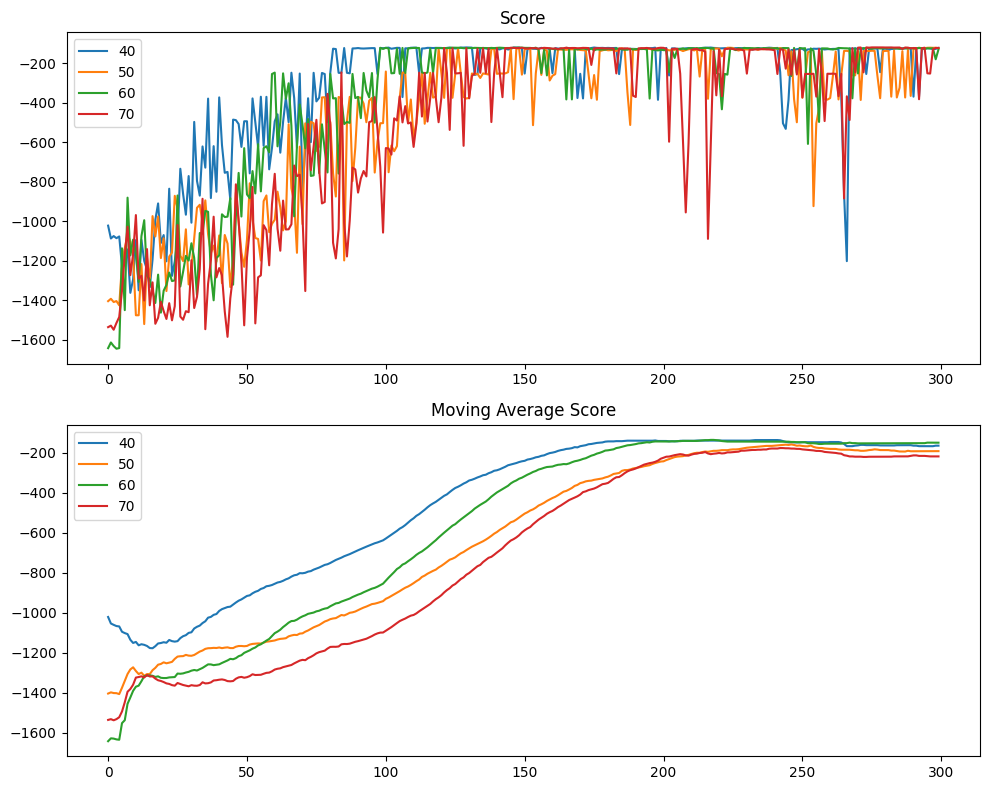

In [11]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(NActions)):
    sns.lineplot(x=episode_number, y=NActions_Score[i], label=NActions[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(NActions)):
    sns.lineplot(x=episode_number, y=NActions_Average[i], label=NActions[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

In [16]:
weights = ['DQN_Weights/MainPendulum_NActions_40.h5', 'DQN_Weights/MainPendulum_NActions_50.h5', 'DQN_Weights/MainPendulum_NActions_60.h5', 'DQN_Weights/MainPendulum_NActions_70.h5']

scores_NActions = []
average_NActions = []
for i in range(len(weights)):
    dqn = DQN(InputShape = 3, load_weights = weights[i], NActions = NActions[i])
    scores, average = RunEpisodes(dqn, 30, save_weights=None)
    scores_NActions.append(scores)
    average_NActions.append(average)


 
List of Parameters:
Number of Actions: 40,
Gamma: 0.97,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 

Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 0, Score : -119.27174313483843, Moving Average : -119.27174313483843, Epsilon : 0.095
Episode 1, Score : -118.70336827352472, Moving Average : -118.98

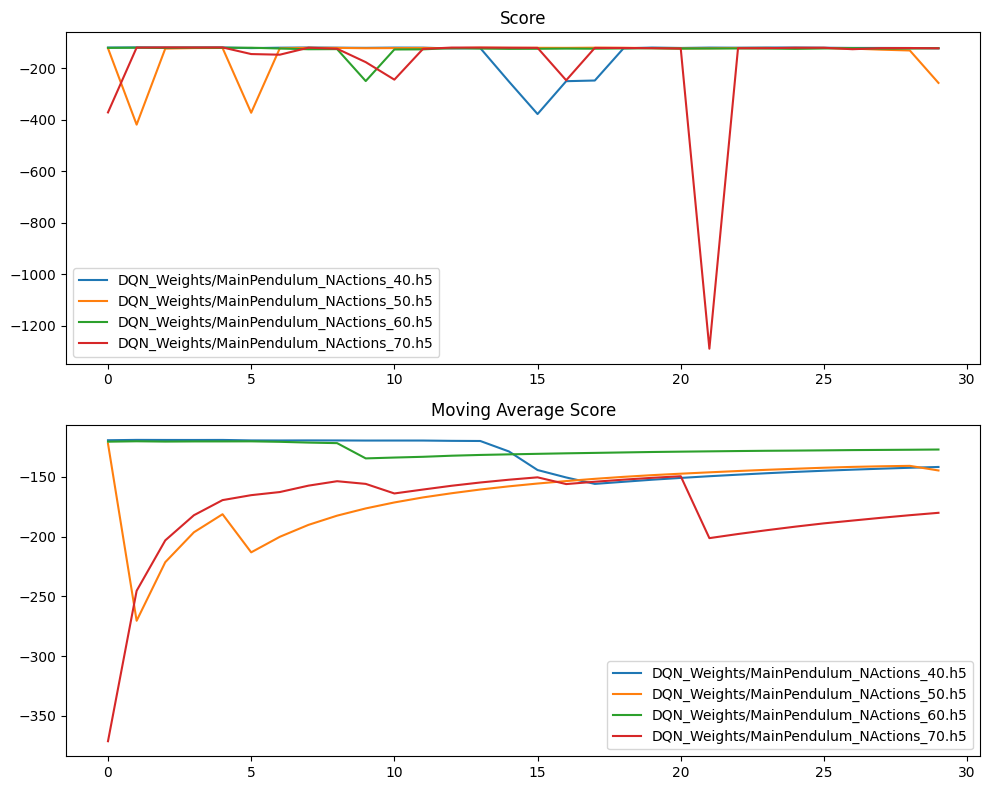

In [17]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
s = np.arange(30)
for i in range(len(NActions)):
    sns.lineplot(x=s, y=scores_NActions[i], label=weights[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(NActions)):
    sns.lineplot(x=s, y=average_NActions[i], label=weights[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

The one that is most stable is 40

## Gamma (Discount Factor)



In [18]:
Gamma_scores = []
Gamma_average = []
for i in Gamma:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = i)
    scores, average = RunEpisodes(dqn, EPISODES, save_weights=f'test/Gamma_{i}.h5')
    Gamma_scores.append(scores)
    Gamma_average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 1,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.

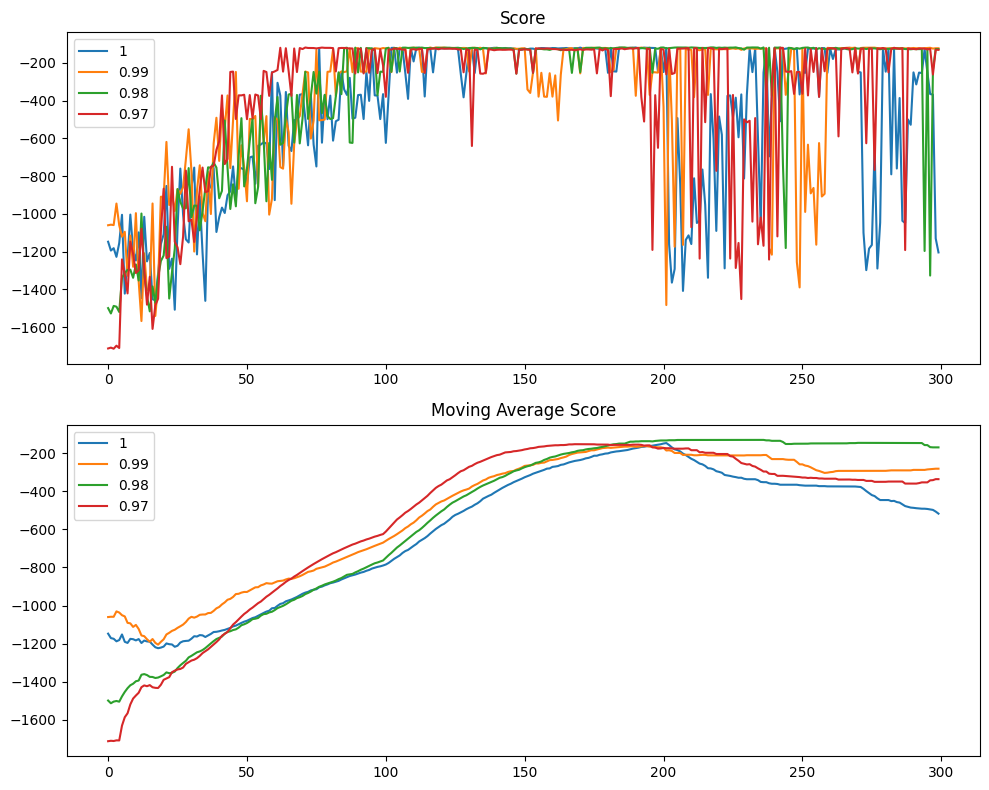

In [19]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Gamma)):
    sns.lineplot(x=episode_number, y=Gamma_scores[i], label=Gamma[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Gamma)):
    sns.lineplot(x=episode_number, y=Gamma_average[i], label=Gamma[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

Load in from weights and test

In [31]:
weights_Gamma = ['DQN_Weights/MainPendulum_Gamma_1.h5', 'DQN_Weights/MainPendulum_Gamma_0.99.h5', 'DQN_Weights/MainPendulum_Gamma_0.98.h5', 'DQN_Weights/MainPendulum_Gamma_0.97.h5']
weights_gamma_score = []
weights_gamma_average = []
for i in range(len(weights_Gamma)):
    dqn = DQN(InputShape = 3, load_weights = weights_Gamma[i], NActions = 40, Gamma = Gamma[i])
    scores, average = RunEpisodes(dqn, 30, save_weights=False, load_weights=True)
    weights_gamma_score.append(scores)
    weights_gamma_average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 1,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.

Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 0, Score : -121.44353142118746, Moving Average : -121.44353142118746, Epsilon : 0.095
Episode 1, Score : -121.9646787448241, Moving Average : -121.704

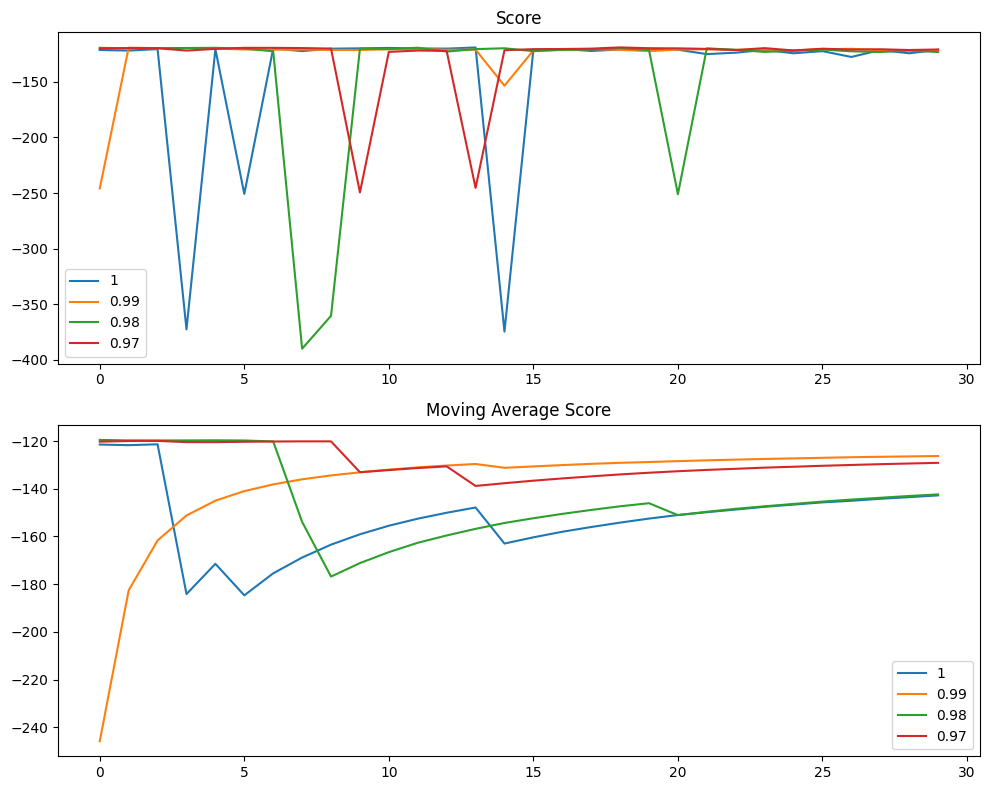

In [33]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Gamma)):
    sns.lineplot(x=s, y=weights_gamma_score[i], label=Gamma[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Gamma)):
    sns.lineplot(x=s, y=weights_gamma_average[i], label=Gamma[i])
plt.title('Moving Average Score')

plt.tight_layout()

After Loading in weights by inspectionn we can say the most stable appears to be a gamma of 0.99

## Penalized Learning Rate for High Score
-  Penalization for a High Score

In [12]:
Low_Score_Adjust_Learning_Rate_Score = []
Low_Score_Adjust_Learning_Rate_Average = []
for i in Low_Score_Adjust_Learning_Rate:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.98, low_penalty=i)
    scores, average = RunEpisodes(dqn, EPISODES, save_weights=f'Low_Score_Adjust_Learning_Rate_{i}.h5', load_weights=False)
    Low_Score_Adjust_Learning_Rate_Score.append(scores)
    Low_Score_Adjust_Learning_Rate_Average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.98,
Learning Rate: 0.001,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95,
Low Penalty: 1.1

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)

Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 0, Score : -1329.8228377904493, Moving Average : -1329.8228377904493, Epsilon : 0.11, learning rate : 0.0011
Episode 1, Score : -1298.889727999729, Mo

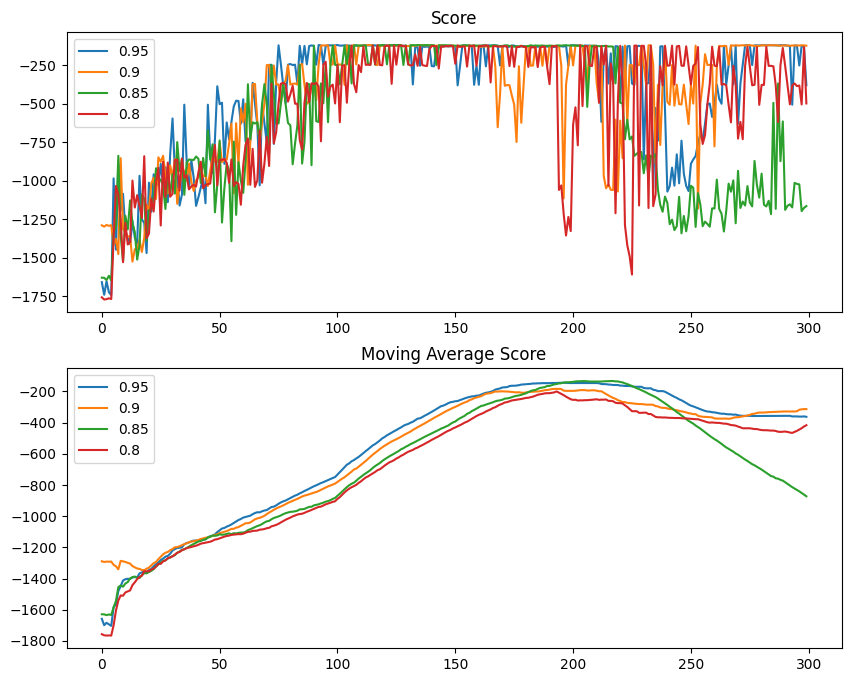

In [50]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(High_Score_Adjust_Learning_Rate)):
    sns.lineplot(x=episode_number, y=High_Score_Adjust_Learning_Rate_Score[i], label=High_Score_Adjust_Learning_Rate[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(High_Score_Adjust_Learning_Rate)):
    sns.lineplot(x=episode_number, y=High_Score_Adjust_Learning_Rate_Average[i], label=High_Score_Adjust_Learning_Rate[i])
plt.title('Moving Average Score')

# plt.tight_layout()
plt.show()

It appears that 0.85

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.98,
Learning Rate: 0.001,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params:

Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 0, Score : -1157.2969542938154, Moving Average : -1157.2969542938154, Epsilon : 0.11, learning rate : 0.00125
Episode 1, Score : -1209.4764919258691, 

<Axes: >

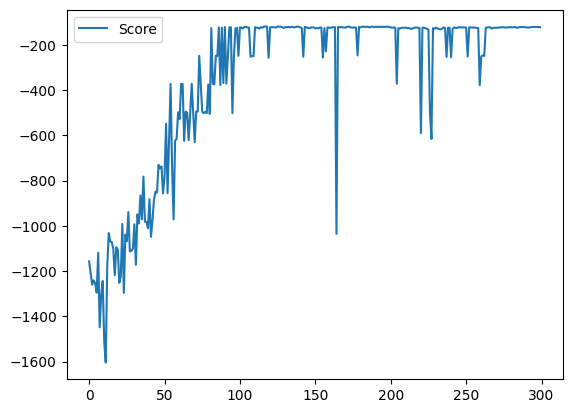

In [66]:
dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.98, high_penalty=0.95)
scores, average = RunEpisodes(dqn, 300, save_weights='testingsomething', load_weights=False)

sns.lineplot(x=episode_number, y=scores, label="Score")

## Epsilon Decay

In [ ]:
Epsilon_Decay_Scores = []
Epsilon_Decay_Average = []
for i in Epsilon_Decay:
    dqn = DQN(InputShape = 3, Epsilon_Decay = i)
    scores, average = RunEpisodes(dqn, EPISODES)
    Epsilon_Decay_Scores.append(scores)
    Epsilon_Decay_Average.append(average)

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Epsilon_Decay)):
    sns.lineplot(x=episode_number, y=Epsilon_Decay_Scores[i], label=Epsilon_Decay[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Epsilon_Decay)):
    sns.lineplot(x=episode_number, y=Epsilon_Decay_Average[i], label=Epsilon_Decay[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

In [ ]:
STOP

## Reward Normalization

Need to adjust Train Function

In [ ]:
Normalization_Score = []
Normalization_average = []
for i in Normalize:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.97)
    scores, average = RunEpisodes(dqn, EPISODES, Normalize=i)
    Normalization_Score.append(scores)
    Normalization_average.append(average)

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Normalize)):
    sns.lineplot(x=episode_number, y=Normalization_Score[i], label=Normalize[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Normalize)):
    sns.lineplot(x=episode_number, y=Normalization_average[i], label=Normalize[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()